# Logistic Regression

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score,f1_score



#Set figure size
sns.set(rc={'figure.figsize':(5,5)})

#Load data
df = pd.read_csv(os.path.join('data','data_filtered.csv'))
df2  = pd.read_csv(os.path.join('data','data_all.csv'))

#Enable CUDA
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

df

,sd,Q25,IQR,sp.ent,sfm,meanfun,mindom,dfrange,label
0,0.241585,0.455971,-0.601712,0.796058,0.925288,1.302489,-0.708404,-0.415794,1
1,-0.114476,-0.105393,0.401743,0.461699,-0.229014,-0.259737,-0.461523,0.412186,0
2,-1.284107,1.726540,-1.169425,-1.599113,-1.269425,1.315527,-0.461523,1.777355,1
3,1.089943,-0.391539,0.786946,0.578250,0.982092,-0.698228,-0.708404,-0.679948,0
4,0.231523,0.681061,-0.527833,0.508050,0.516462,1.167348,-0.708404,-1.343664,1
...,...,...,...,...,...,...,...,...,...
3163,1.087355,-0.480803,0.982768,1.385949,1.667369,-0.969765,-0.338082,-1.208257,0
3164,-1.471392,0.863030,-1.176833,-0.555301,-1.128432,0.530223,1.143207,-1.214917,1
3165,0.644400,-0.395149,0.953317,0.626947,0.305185,-0.983770,-0.708404,-0.688828,0
3166,1.557415,-0.558784,0.970942,1.076622,1.232644,-0.441604,-0.708404,-0.005133,0


In [2]:
feature_size = len(df.drop(['label'],axis=1).columns)
print(f'Number of Features: {feature_size}')

train_x, test_x, train_y, test_y = train_test_split(
    df.drop(['label'], axis=1), df['label'], test_size=0.2, random_state=42)


Number of Features: 8


In [3]:
def run(C:float = 1.0, #Regularisation parameter
        tol:float = 1e-4, #Tolerance to stop
        fit_intercept:bool = True, #Specifies if an intercept should be added to the decision function
        show:bool = True):
    
    lr_clf = LogisticRegression(C=C,
                                tol=tol,
                                fit_intercept=fit_intercept,
                                random_state=1).fit(train_x, train_y)
    prediction = lr_clf.predict(test_x)
    
    # Generate Accuracy, Precision, Recall, F1 Score
    accuracy = accuracy_score(prediction, test_y)
    precision = precision_score(prediction, test_y)
    recall = recall_score(prediction, test_y)
    f1 = f1_score(prediction, test_y)
    
    if not show:
        return (accuracy,precision,recall,f1)
    
    #Generate confusion matrix
    cm = confusion_matrix(test_y, prediction)
    count      = ["{0:0.0f}".format(v) for v in cm.flatten()]
    percentage = ["{0:.2%}".format(v) for v in cm.flatten()/np.sum(cm)]
    labels = np.asarray([f"{v1}\n{v2}" for v1, v2 in
              zip(count,percentage)]).reshape(2,2)
    sns.heatmap(cm,fmt='',annot=labels)
    
    # Print to standard output
    print('Accuracy:\t%.3f' % accuracy)
    print('Precision:\t%.3f' % precision)
    print('Recall:  \t%.3f' % recall)
    print('F1 Score:\t%.3f' % f1)
    
    return [accuracy,precision,recall,f1]

# Evaluation

## Varying <code>tol</code> and <code>C</code> simultaneously

In [4]:
data = []

for c in np.arange(0.1,10,0.05):
    print(c,end='\r')
    for tol in np.arange(1e-5,1e-3,5e-5):
        a,_,_,_ = run(C=c, tol=tol,show=False)
        
        #Tally metrics
        data.append([a,c,tol])

In [89]:
accuracies = np.array(data).transpose()[0]

a, = np.where(accuracies == 0.9779179810725552)
print(f'Number of data points: {len(accuracies)}')
print(f'Number of data points equal to 0.9779179810725552:{len(a)}')

Number of data points: 3960
Number of data points equal to 0.9779179810725552:3960


From the above, it seems that varying the regularisation parameter and the tolerance simultaneously does not have any effect on the performance of the Logistic Regression.

## Not adding a bias to the linear decision surface

Accuracy:	0.972
Precision:	0.958
Recall:  	0.984
F1 Score:	0.971


[0.9716088328075709,
 0.9584664536741214,
 0.9836065573770492,
 0.9708737864077669]

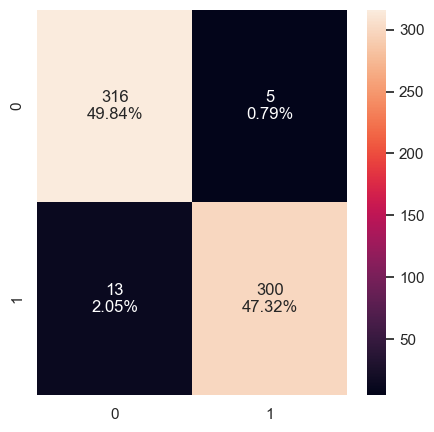

In [90]:
run(fit_intercept=False)

Accuracy:	0.978
Precision:	0.971
Recall:  	0.984
F1 Score:	0.977


[0.9779179810725552,
 0.9712460063897763,
 0.9838187702265372,
 0.9774919614147909]

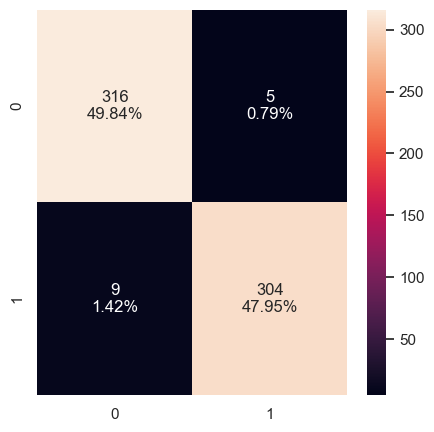

In [92]:
run(fit_intercept=True)

As can be seen above, when not adding a y-intercept to the decision surface the model misclassifies 4 females more than if it had. This miniscule change in performance could be attributed to the fact that the data is already standardised around 0, and hence a y-intercept is not needed to elevate the decision plane.